# **Facial Expressions Saturdays Ai**

Proyecto de la primera edición de Donostia de Saturdays Ai 2020.


1. Importación de librerías

In [2]:
import numpy as np 
import pandas as pd
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from skimage import io


## Added libraries by Hooshiar
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from skimage.util import img_as_float

# these lib are for applying mask
import dlib
import numpy as np
import imutils
#import cMake
# this lib are to compute Haar Wavelet of an image
import pywt


# settings: Load from the pre processed data:
# in case the images are preprocessed, they will be loaded from a specific folder, rather than being generated
loadPreprocessed = False;

featureMethod = 0   # 0 is for HoG, 1 is for Haar

loadDir = "data"

if loadPreprocessed:
    loadDir = "maskdata"

In [3]:
print(tf.version.VERSION)

2.3.0


In [4]:
# this function is to apply mask on the input images
def maskify(img):
    ## set directories
    #os.chdir("C:\Users\ZolfaghH\Downloads\facial\Facial_Expression_Saturdays-master")
    #path ="predict/4disguested.jpg"

    #Initialize color [color_type] = (Blue, Green, Red)
    color_blue = (254,207,110)
    color_cyan = (255,200,0)
    color_black = (0, 0, 0)

    # Use input () function to capture from user requirements for mask type and mask colour
    choice1 = 1 #input("Please select the choice of mask color\nEnter 1 for blue\nEnter 2 for black:\n")
    #choice1 = int(choice1)

    if choice1 == 1:
        choice1 = color_blue
        #print('You selected mask color = blue')
    elif choice1 == 2:
        choice1 = color_black
        #print('You selected mask color = black')
    else:
        print("invalid selection, please select again.")
        #input("Please select the choice of mask color\nEnter 1 for blue\nEnter 2 for black :\n")


    choice2 = 3 #input("Please enter choice of mask type coverage \nEnter 1 for high \nEnter 2 for medium \nEnter 3 for low :\n")
    #choice2 = int(choice2)


    # print(choice2)



    # Loading the image and resizing, converting it to grayscale
    #img= cv2.imread(path)
    #img = imutils.resize(img, width = 500)
    
    if(len(img.shape)>2):
        gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img    

    # Initialize dlib's face detector
    detector = dlib.get_frontal_face_detector()

    """
    Detecting faces in the grayscale image and creating an object - faces to store the list of bounding rectangles coordinates
    The "1" in the second argument indicates that we should upsample the image 1 time.  
    This will make everything bigger and allow us to detect more faces
    """

    faces = detector(gray, 1)

    # printing the coordinates of the bounding rectangles
    #print(faces)
    #print("Number of faces detected: ", len(faces))

    """
    # Using a for loop in order to extract the specific coordinates (x1,x2,y1,y2)
    for face in faces:
      x1 = face.left()
      y1 = face.top()
      x2 = face.right()
      y2 = face.bottom()
      # Drawing a rectangle around the face detected
      cv2.rectangle(img, (x1,y1), (x2,y2),(0,255,0),3)
    cv2.imshow("image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    """

    """
    Detecting facial landmarks using facial landmark predictor dlib.shape_predictor from dlib library
    This shape prediction method requires the file called "shape_predictor_68_face_landmarks.dat" to be downloaded
    Source of file: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    """
    # Path of file
    p = "shape_predictor_68_face_landmarks.dat"
    # Initialize dlib's shape predictor
    predictor = dlib.shape_predictor(p)

    # Get the shape using the predictor
    #img3=cv2.imread(path)
    for face in faces:
        #img3=cv2.imread(path)
        landmarks = predictor(gray, face)

        # for n in range(0,68):
        #     x = landmarks.part(n).x
        #     y = landmarks.part(n).y
        #     img_landmark = cv2.circle(img, (x, y), 4, (0, 0, 255), -1)


        points = []
        for i in range(1, 16):
            point = [landmarks.part(i).x, landmarks.part(i).y]
            points.append(point)
        # print(points)

        # Coordinates for the additional 3 points for wide, high coverage mask - in sequence
        mask_a = [((landmarks.part(42).x), (landmarks.part(15).y)),
                  ((landmarks.part(27).x), (landmarks.part(27).y)),
                  ((landmarks.part(39).x), (landmarks.part(1).y))]

        # Coordinates for the additional point for wide, medium coverage mask - in sequence
        mask_c = [((landmarks.part(29).x), (landmarks.part(29).y))]

        # Coordinates for the additional 5 points for wide, low coverage mask (lower nose points) - in sequence
        mask_e = [((landmarks.part(35).x), (landmarks.part(35).y)),
                  ((landmarks.part(34).x), (landmarks.part(34).y)),
                  ((landmarks.part(33).x), (landmarks.part(33).y)),
                  ((landmarks.part(32).x), (landmarks.part(32).y)),
                  ((landmarks.part(31).x), (landmarks.part(31).y))]

        fmask_a = points + mask_a
        fmask_c = points + mask_c
        fmask_e = points + mask_e

        # mask_type = {1: fmask_a, 2: fmask_c, 3: fmask_e}
        # mask_type[choice2]


        # Using Python OpenCV – cv2.polylines() method to draw mask outline for [mask_type]:
        # fmask_a = wide, high coverage mask,
        # fmask_c = wide, medium coverage mask,
        # fmask_e  = wide, low coverage mask

        fmask_a = np.array(fmask_a, dtype=np.int32)
        fmask_c = np.array(fmask_c, dtype=np.int32)
        fmask_e = np.array(fmask_e, dtype=np.int32)

        mask_type = {1: fmask_a, 2: fmask_c, 3: fmask_e}
        mask_type[choice2]


        # change parameter [mask_type] and color_type for various combination
        img2 = cv2.polylines(img, [mask_type[choice2]], True, choice1, thickness=2, lineType=cv2.LINE_8)

        # Using Python OpenCV – cv2.fillPoly() method to fill mask
        # change parameter [mask_type] and color_type for various combination
        img3 = cv2.fillPoly(img2, [mask_type[choice2]], choice1, lineType=cv2.LINE_AA)
        
        #convert to grayscale
        
    try:
        if(len(img3.shape)>2):
            img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
    except UnboundLocalError:
        img3=cv2.imread(path)
        return img3, False;
        
            

    # cv2.imshow("image with mask outline", img2)
    #plt.imshow(img3)

    
    return img3, True;

In [5]:
def computeHaar(img):
    h, w = img.shape
    
    img = cv2.resize(img, (w*2,h*2))
    # Convert to float for more resolution for use with pywt
    img = np.float32(img)
    img /= 255

    # Wavelet transform of image,
    coeffs2 = pywt.dwt2(img, 'haar')
    LL, (LH, HL, HH) = coeffs2
    img = LH + HL + HH   # summation of horizental an vertical and diagonal

    #fig = plt.figure(figsize=(12, 3))
    #for i, a in enumerate([LL, LH, HL, HH]):
    #    ax = fig.add_subplot(1, 4, i + 1)
    #    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    #    ax.set_title(titles[i], fontsize=10)
    #    ax.set_xticks([])
    #    ax.set_yticks([])

    #fig.tight_layout()
    #plt.show()

    img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    img = np.uint8(img)

    #plt.imshow(img)
    #cv2.imwrite("HaarWavelet.jpg", img)

    #print(img[0,0])
    
    return img

def computeHoG(img):
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(2, 2),cells_per_block=(1, 1), visualize=True, multichannel=False)
    hog_image = cv2.normalize(hog_image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    hog_image = np.uint8(hog_image)
    return hog_image

In [6]:
#  optional section: To validate the function of faceFeatures
path = "predict/3surprised.jpg"
img = imread(path)

if(len(img.shape)>2):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img, stat = maskify(img)

feat_img = computeHaar(img)

img, stat = faceFeatures(img, feat_img)
print(stat)
plt.imshow(img)

NameError: name 'faceFeatures' is not defined

2. Importación data training

In [9]:
#feature extraction on training data

loc1 = loadDir + '/train/0'
loc2 = loadDir + '/train/1'
loc3 = loadDir + '/train/2'
loc4 = loadDir + '/train/3'
loc5 = loadDir + '/train/4'
loc6 = loadDir + '/train/5'
loc7 = loadDir + '/train/6'

features = []
stat=True

if loadPreprocessed:

    for i in tqdm(os.listdir(loc1)):
        features.append(cv2.imread(os.path.join(loc1,i),0))

    for i in tqdm(os.listdir(loc2)):
        features.append(cv2.imread(os.path.join(loc2,i),0))

    for i in tqdm(os.listdir(loc3)):
        features.append(cv2.imread(os.path.join(loc3,i),0))

    for i in tqdm(os.listdir(loc4)):
        features.append(cv2.imread(os.path.join(loc4,i),0))

    for i in tqdm(os.listdir(loc5)):
        features.append(cv2.imread(os.path.join(loc5,i),0))

    for i in tqdm(os.listdir(loc6)):
        features.append(cv2.imread(os.path.join(loc6,i),0))

    for i in tqdm(os.listdir(loc7)):
        features.append(cv2.imread(os.path.join(loc7,i),0))

else:
    
##### modified code by Hooshiar to read image and compute HoG    
    for i in tqdm(os.listdir(loc1)):
        path = os.path.join(loc1,i)
        img = imread(path)
        # maskify
       # img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

           # cv2.imwrite("mask"+path, img_comb)
            features.append(img_comb)

    for i in tqdm(os.listdir(loc2)):
        path = os.path.join(loc2,i)
        img = imread(path)
        # maskify
        #img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

           # cv2.imwrite("mask"+path, img_comb)
            features.append(img_comb)

    for i in tqdm(os.listdir(loc3)):
        path = os.path.join(loc3,i)
        img = imread(path)
        # maskify
       # img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

           # cv2.imwrite("mask"+path, img_comb)
            features.append(img_comb)

    for i in tqdm(os.listdir(loc4)):
        path = os.path.join(loc4,i)
        img = imread(path)
        # maskify
       # img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

           # cv2.imwrite("mask"+path, img_comb)
            features.append(img_comb)

    for i in tqdm(os.listdir(loc5)):
        path = os.path.join(loc5,i)
        img = imread(path)
        # maskify
        #img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

           # cv2.imwrite("mask"+path, img_comb)
            features.append(img_comb)

    for i in tqdm(os.listdir(loc6)):
        path = os.path.join(loc6,i)
        img = imread(path)
        # maskify
       # img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

         #   cv2.imwrite("mask"+path, img_comb)
            features.append(img_comb)

    for i in tqdm(os.listdir(loc7)):
        path = os.path.join(loc7,i)
        img = imread(path)
        # maskify
       # img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

          #  cv2.imwrite("mask"+path, img_comb)
            features.append(img_comb)


100%|██████████████████████████████████████████████████████████████████████████████| 4965/4965 [10:19<00:00,  8.02it/s]


In [10]:
labels = []

for i in os.listdir('data/train/0'):
    labels.append(0)
for i in os.listdir('data/train/1'):
    labels.append(1)
for i in os.listdir('data/train/2'):
    labels.append(2)
for i in os.listdir('data/train/3'):
    labels.append(3)
for i in os.listdir('data/train/4'):
    labels.append(4)
for i in os.listdir('data/train/5'):
    labels.append(5)
for i in os.listdir('data/train/6'):
    labels.append(6)

[141   0 113]


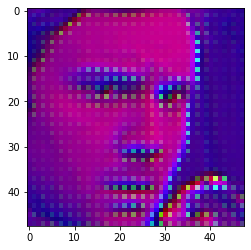

In [11]:
print(features[0][20,20])
plt.imshow(features[0])

In [12]:
#feature extraction on testing data

loc1 = loadDir + '/test/0'
loc2 = loadDir + '/test/1'
loc3 = loadDir + '/test/2'
loc4 = loadDir + '/test/3'
loc5 = loadDir + '/test/4'
loc6 = loadDir + '/test/5'
loc7 = loadDir + '/test/6'


test_features = []
stat=True

if loadPreprocessed:

    for i in tqdm(os.listdir(loc1)):
        test_features.append(cv2.imread(os.path.join(loc1,i),0))

    for i in tqdm(os.listdir(loc2)):
        test_features.append(cv2.imread(os.path.join(loc2,i),0))

    for i in tqdm(os.listdir(loc3)):
        test_features.append(cv2.imread(os.path.join(loc3,i),0))

    for i in tqdm(os.listdir(loc4)):
        test_features.append(cv2.imread(os.path.join(loc4,i),0))

    for i in tqdm(os.listdir(loc5)):
        test_features.append(cv2.imread(os.path.join(loc5,i),0))

    for i in tqdm(os.listdir(loc6)):
        test_features.append(cv2.imread(os.path.join(loc6,i),0))

    for i in tqdm(os.listdir(loc7)):
        test_features.append(cv2.imread(os.path.join(loc7,i),0))

else:
    
    # Modified by Hooshiar to generate HoGof image and just use it for testing

    for i in tqdm(os.listdir(loc1)):
        path = os.path.join(loc1,i)
        img = imread(path)
        # maskify
       # img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

         #   cv2.imwrite("mask"+path, img_comb)
            test_features.append(img_comb)

    for i in tqdm(os.listdir(loc2)):
        path = os.path.join(loc2,i)
        img = imread(path)
        # maskify
      #  img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

            #cv2.imwrite("mask"+path, img_comb)
            test_features.append(img_comb)

    for i in tqdm(os.listdir(loc3)):
        path = os.path.join(loc3,i)
        img = imread(path)
        # maskify
       # img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

           # cv2.imwrite("mask"+path, img_comb)
            test_features.append(img_comb)

    for i in tqdm(os.listdir(loc4)):
        path = os.path.join(loc4,i)
        img = imread(path)
        # maskify
       # img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

           # cv2.imwrite("mask"+path, img_comb)
            test_features.append(img_comb)

    for i in tqdm(os.listdir(loc5)):
        path = os.path.join(loc5,i)
        img = imread(path)
        # maskify
        #img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

          #  cv2.imwrite("mask"+path, img_comb)
            test_features.append(img_comb)

    for i in tqdm(os.listdir(loc6)):
        path = os.path.join(loc6,i)
        img = imread(path)
        # maskify
       # img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

          #  cv2.imwrite("mask"+path, img_comb)
            test_features.append(img_comb)

    for i in tqdm(os.listdir(loc7)):
        path = os.path.join(loc7,i)
        img = imread(path)
        # maskify
       # img, stat = maskify(img)
        
        if stat==True:
            if(len(img.shape)>2):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_img = computeHoG(img)
            haar_img = computeHaar(img)

            img_comb = np.zeros((48,48,3), np.uint8)
            img_comb[:,:,0] = img
            img_comb[:,:,1] = hog_img
            img_comb[:,:,2] = haar_img

          #  cv2.imwrite("mask"+path, img_comb)
            test_features.append(img_comb)

100%|████████████████████████████████████████████████████████████████████████████████| 626/626 [01:17<00:00,  8.06it/s]


In [13]:
labels_test = []
for i in os.listdir('data/test/0'):
    labels_test.append(0)
for i in os.listdir('data/test/1'):
    labels_test.append(1)
for i in os.listdir('data/test/2'):
    labels_test.append(2)
for i in os.listdir('data/test/3'):
    labels_test.append(3)
for i in os.listdir('data/test/4'):
    labels_test.append(4)
for i in os.listdir('data/test/5'):
    labels_test.append(5)
for i in os.listdir('data/test/6'):
    labels_test.append(6)

In [14]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

In [15]:
len(features)

28709

In [16]:
train_data['emotion'] = labels
train_data['pixel_values'] = features
test_data['emotion'] = labels_test
test_data['pixel_values'] = test_features

In [17]:
test_data.head()

,emotion,pixel_values
0,0,"[[[179, 0, 101], [175, 0, 102], [176, 0, 103],..."
1,0,"[[[103, 0, 121], [126, 0, 136], [109, 0, 151],..."
2,0,"[[[27, 0, 162], [29, 0, 133], [88, 0, 139], [3..."
3,0,"[[[11, 0, 132], [11, 0, 132], [11, 0, 132], [1..."
4,0,"[[[80, 0, 117], [82, 0, 99], [107, 0, 92], [14..."


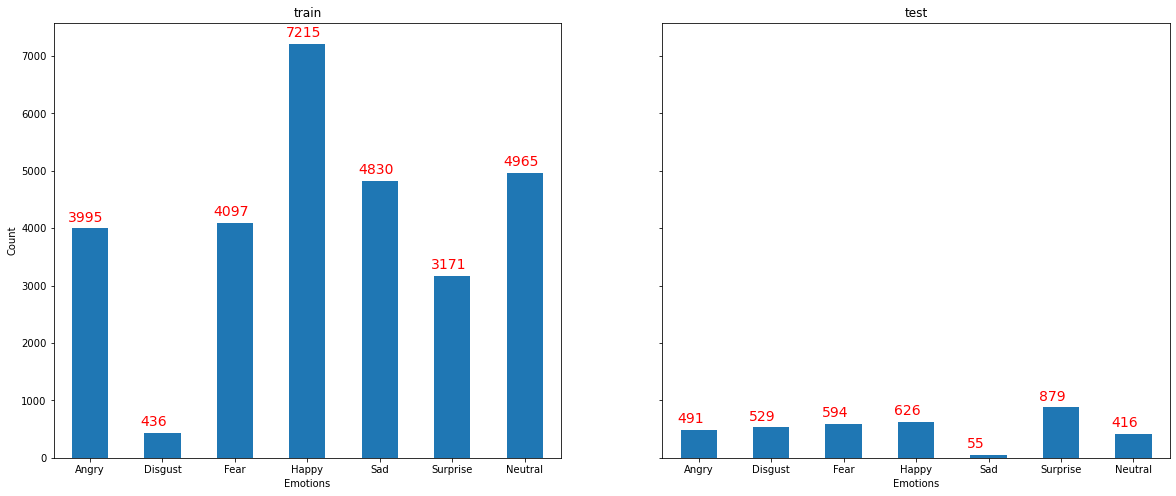

In [18]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Count")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
         axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='red',
                    rotation=0)

import matplotlib.pyplot as plt   
fig, axes = plt.subplots(1,2, figsize=(20,8), sharey=True)
setup_axe(axes[0],train_data,'train')
setup_axe(axes[1],test_data,'test')
plt.show()

In [19]:
features = np.array(features).reshape(-1,48,48,3)
test_features = np.array(test_features).reshape(-1,48,48,3)

features = features/255
test_features = test_features/255

labels = np_utils.to_categorical(labels)
labels_test =np_utils.to_categorical(labels_test)

In [20]:
print('Training features shape ',features.shape)
print('Training labels shape',labels.shape)
print('Testing features shape ',test_features.shape)
print('Testing labels shape',labels_test.shape)

Training features shape  (28709, 48, 48, 3)
Training labels shape (28709, 7)
Testing features shape  (3590, 48, 48, 3)
Testing labels shape (3590, 7)


In [21]:
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization,MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop

In [22]:
def create_model():
    model = Sequential()
    input_shape = (48,48,3)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    
    model.add(Dense(7))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

In [23]:
model = create_model()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       4

In [25]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 best_only_model=True,
                                                 verbose=1)

In [26]:
model.save_weights(checkpoint_path.format(epoch=0))

In [27]:
history = model.fit(x=features, 
            y=labels,
            epochs=10, 
            steps_per_epoch = len(features)/64,
            verbose=1, 
            callbacks = [cp_callback],
            validation_data=(test_features,labels_test),  
            validation_steps = len(test_features)/64)


Epoch 1/10
449/448 [==============================] - ETA: 0s - loss: 1.8335 - accuracy: 0.2655
Epoch 00001: saving model to training_2\cp.ckpt
449/448 [==============================] - 1014s 2s/step - loss: 1.8335 - accuracy: 0.2655 - val_loss: 1.5959 - val_accuracy: 0.3716
Epoch 2/10
449/448 [==============================] - ETA: 0s - loss: 1.5625 - accuracy: 0.3920
Epoch 00002: saving model to training_2\cp.ckpt
449/448 [==============================] - 1034s 2s/step - loss: 1.5625 - accuracy: 0.3920 - val_loss: 1.6336 - val_accuracy: 0.3504
Epoch 3/10
449/448 [==============================] - ETA: 0s - loss: 1.4072 - accuracy: 0.4580
Epoch 00003: saving model to training_2\cp.ckpt
449/448 [==============================] - 1048s 2s/step - loss: 1.4072 - accuracy: 0.4580 - val_loss: 1.3297 - val_accuracy: 0.4911
Epoch 4/10
449/448 [==============================] - ETA: 0s - loss: 1.3033 - accuracy: 0.5030
Epoch 00004: saving model to training_2\cp.ckpt
449/448 [================

In [349]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

In [350]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 best_only_model=True,
                                                 verbose=1)

In [351]:
model.fit(x=features, 
            y=labels,
            epochs=10, 
            steps_per_epoch = len(features)/64,
            verbose=1, 
            callbacks = [cp_callback],
            validation_data=(test_features,labels_test),  
            validation_steps = len(test_features)/64)

Epoch 1/10
312/311 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 0.9880
Epoch 00001: saving model to training_2\cp.ckpt
312/311 [==============================] - 810s 3s/step - loss: 0.0395 - accuracy: 0.9880 - val_loss: 3.0935 - val_accuracy: 0.5414
Epoch 2/10
312/311 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9778
Epoch 00002: saving model to training_2\cp.ckpt
312/311 [==============================] - 797s 3s/step - loss: 0.0658 - accuracy: 0.9778 - val_loss: 2.8444 - val_accuracy: 0.5187
Epoch 3/10
312/311 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9748
Epoch 00003: saving model to training_2\cp.ckpt
312/311 [==============================] - 735s 2s/step - loss: 0.0739 - accuracy: 0.9748 - val_loss: 2.9866 - val_accuracy: 0.5349
Epoch 4/10
312/311 [==============================] - ETA: 0s - loss: 0.0551 - accuracy: 0.9801
Epoch 00004: saving model to training_2\cp.ckpt
312/311 [===================

In [352]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

In [344]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 best_only_model=True,
                                                 verbose=1)

In [220]:
history =model.fit(x=features, 
            y=labels,
            epochs=1, 
            steps_per_epoch = len(features)/64,
            verbose=1, 
            callbacks = [cp_callback],
            validation_data=(test_features,labels_test),  
            validation_steps = len(test_features)/64)

449/448 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9743
Epoch 00001: saving model to training_2\cp.ckpt
449/448 [==============================] - 773s 2s/step - loss: 0.0771 - accuracy: 0.9743 - val_loss: 2.7980 - val_accuracy: 0.5252


In [28]:
!mkdir -p saved_model
model.save('saved_model/3Channelmodel')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


In [ ]:
from sklearn.externals import joblib 
joblib.dump(model, 'modelo_entrenado.pkl') 

In [29]:
new_model = tf.keras.models.load_model('saved_model/3Channelmodel')

In [30]:
loss, acc = new_model.evaluate(test_features, labels_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

113/113 - 32s - loss: 0.8642 - accuracy: 0.6886
Restored model, accuracy: 68.86%


In [31]:
test_true = np.argmax(labels_test, axis=1)
test_pred = np.argmax(model.predict(test_features), axis=1)
print("CNN Model Accuracy on testing data: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on testing data: 0.6886


In [ ]:
predicted_classes = cnn_model.predict_classes(test_features)

In [32]:
from sklearn.metrics import classification_report

print(classification_report(test_true, test_pred))

              precision    recall  f1-score   support

           0       0.49      0.82      0.61       491
           1       0.76      0.62      0.68        55
           2       0.66      0.46      0.54       529
           3       0.87      0.87      0.87       879
           4       0.65      0.46      0.54       594
           5       0.84      0.75      0.79       416
           6       0.66      0.70      0.68       626

    accuracy                           0.69      3590
   macro avg       0.70      0.67      0.67      3590
weighted avg       0.71      0.69      0.69      3590



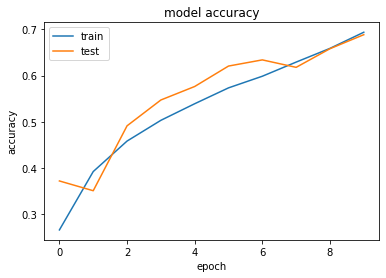

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

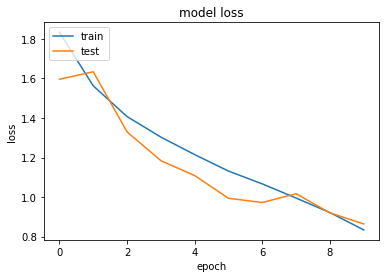

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()